In [1]:
import csv
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

Using TensorFlow backend.


In [2]:
DS = pd.read_csv("ObjectSubset150SentenceLength.csv")

In [3]:
DS['tag'].fillna('text', inplace=True)

In [4]:
words = list(set(DS["word"].values))
n_words = len(words)
tags = list(set(DS["tag"].values))
n_tags = len(tags)


In [5]:
tags

['text', 'object']

In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("text_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]

getter = SentenceGetter(DS)
sentences = getter.sentences


In [7]:
labels = [[s[1] for s in sent] for sent in sentences]
sentences = [" ".join([s[0] for s in sent]) for sent in sentences]
sentences[0]


'26.05.09 patsient hospitaliseeritud erütrotsüütide ülekandeks, 2 doosi RR 120/85 temperatuur 37.7. Võetud vereanalüüsid. Enesetunne rahuldav.'

In [8]:
print(labels[0])


['text', 'text', 'text', 'text', 'text', 'text', 'text', 'object', 'object', 'text', 'text', 'text', 'text', 'text', 'text']


In [9]:
# from collections import Counter
from keras.preprocessing.sequence import pad_sequences

# word_cnt = Counter(DS["word"].values)
# vocabulary = set(w[0] for w in word_cnt.most_common(5000))


In [10]:
max_len = 150
word2idx = {w: i + 2 for i, w in enumerate(words)}

word2idx["UNK"] = 1
word2idx["PAD"] = 0
tags2 = ["PAD","text","object"]
tag2idx = {t: i for i, t in enumerate(tags2)}
# tag2idx["PAD"] = 0


In [11]:
tag2idx

{'PAD': 0, 'text': 1, 'object': 2}

In [12]:
idx2word = {i: w for w, i in word2idx.items()}

In [13]:
X = [[word2idx.get(w, word2idx["PAD"]) for w in s.split()] for s in sentences]


In [14]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["PAD"],truncating="post")


In [15]:
y = [[tag2idx[l_i] for l_i in l] for l in labels]


In [16]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["PAD"],truncating="post")


In [17]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=2018)


In [18]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional


In [19]:
word_input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 2, output_dim=20, input_length=max_len)(word_input)
model = SpatialDropout1D(0.3)(model)
model = Bidirectional(LSTM(units=20, return_sequences=True, recurrent_dropout=0.5))(model)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(model)


In [20]:
model = Model(word_input, out)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [21]:
history = model.fit(X_tr, y_tr.reshape(*y_tr.shape, 1),
                    batch_size=32, epochs=10,
                    validation_split=0.1, verbose=1)


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9822 samples, validate on 1092 samples
Epoch 1/10
9822/9822 [==============================] - 65s 7ms/step - loss: 0.1728 - accuracy: 0.9514 - val_loss: 0.0383 - val_accuracy: 0.9901
Epoch 2/10
9822/9822 [==============================] - 72s 7ms/step - loss: 0.0299 - accuracy: 0.9910 - val_loss: 0.0182 - val_accuracy: 0.9947
Epoch 3/10
9822/9822 [==============================] - 70s 7ms/step - loss: 0.0142 - accuracy: 0.9955 - val_loss: 0.0097 - val_accuracy: 0.9969
Epoch 4/10
9822/9822 [==============================] - 75s 8ms/step - loss: 0.0072 - accuracy: 0.9979 - val_loss: 0.0070 - val_accuracy: 0.9979
Epoch 5/10
9822/9822 [==============================] - 79s 8ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0060 - val_accuracy: 0.9982
Epoch 6/10
9822/9822 [==============================] - 79s 8ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0055 - val_accuracy: 0.9984
Epoch 7/10
9822/9822 [==============================] - 79s 8ms/step - loss: 0.001

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 20)           554860    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 20)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 40)           6560      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 3)            123       
Total params: 561,543
Trainable params: 561,543
Non-trainable params: 0
_________________________________________________________________


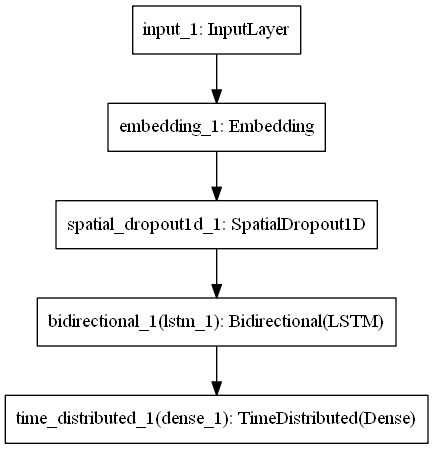

In [22]:
from keras.utils import plot_model
plot_model(model, to_file='wordEmbeddingmodel.png')


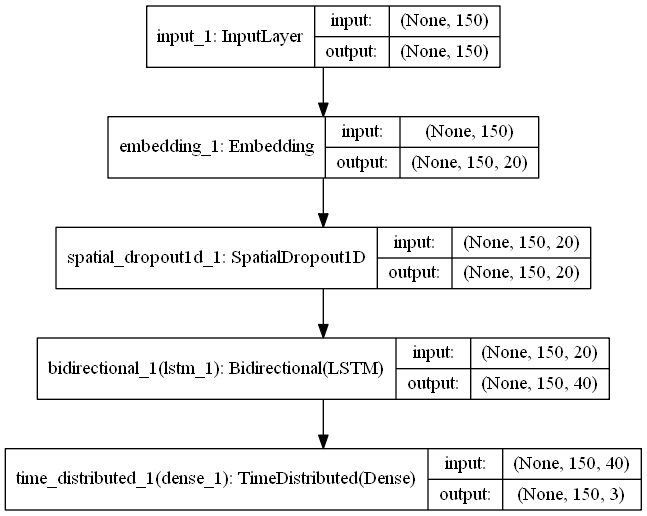

In [23]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='wordEmbeddingmodel_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
hist = pd.DataFrame(history.history)


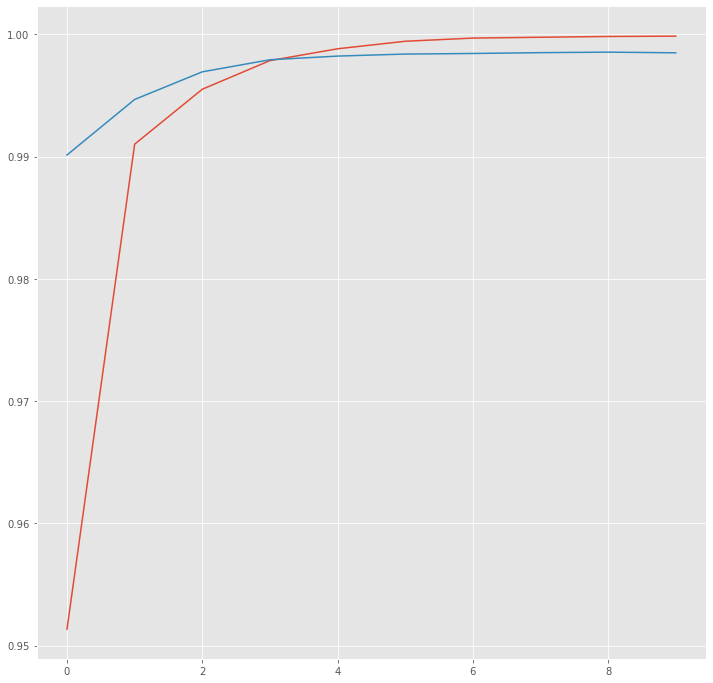

In [23]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()


In [24]:
y_pred = model.predict(X_te)

In [25]:
idx2tag = {i: w for w, i in tag2idx.items()}

In [26]:
i = 10
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], y_te[i], p):
    if t != 0: #PAD
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
RR             : object object
117/84         : object object
,pulss         : text  text
87             : text  text
Cor            : text  text
toonid         : text  text
arütmilised    : text  text
.              : text  text
jalgadel       : text  text
turseid        : text  text
ei             : text  text
ole            : text  text
.              : text  text
Kui            : text  text
RR             : object object
langeb         : text  object
väga           : text  text
madalale       : text  text
,              : text  text
siis           : text  text
võib           : text  text
mõned          : text  text
päevad         : text  text
ära            : text  text
jätta          : text  text
Raweli         : text  text


In [27]:
len(y_pred)

2729

### Wrong Tags


In [28]:
j = 0
for i in range(len(y_pred)):
    p = np.argmax(y_pred[i], axis=-1)
#     print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
#     print(30 * "=")
    for w, t, pred in zip(X_te[i], y_te[i], p):
        if idx2word[w] != "": #PAD
            if idx2tag[t] != idx2tag[pred]:
                print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))
                j = j+1


43,RR          : object text
puhtad.RR130/90: object text
langeb         : text  object
/106           : text  object
/106           : text  object
ebaregulaarne,fr.87/min.RR-125/100: object text
RR152/97mmHg   : object text
157            : object text
RR108/72mmHg   : object text
p/s)RR-130/70mmHg.: object text
72/            : text  object
RR250.110mmhg, : object text
piim)RR-150/80mmHg.: object text
pulss84        : text  object
KORRAS.        : object text
KOORMUSTEST-KORRAS: object text
RR119/73mmHg   : object text
155/95         : object text
Pikkus-174cm,  : object text
RR-100/54mmHg, : object text
RR108/74       : object text
RR156/92mmHg   : object text
Nõustamine.RR140/80: object text
RR125/80.71x   : object text
.RR134/95      : object text
suhtes.RR140/80mmhg: object text
RR119/77mmHg   : object text
2.3.RR         : object text
kõikumised.RR  : object text
140-90mmhg     : object text
130/82         : object text
sööki.RR-136/74mmHG.: object text
/62            : text  ob

�ldveri.RR     : object text
110/80.Borrelia: object text
RR140-90mmhg.  : object text
RR-144/70mmhg, : object text
mmHg,fr.73     : text  object
x/min,SpO2     : text  object
RR140/85mmHg   : object PAD
pearinglus,RR170/80: object text
70/min.RR      : object text
hommikused     : text  object
:RR            : object text
155/97         : object text
RR,            : object text
169cm          : text  object
RR135/86mmHg   : object text
RR-134/80mmHg. : object text
152/96         : text  object
RR136-78mmhg   : object text
Cor-akts.regul.fr.70x: text  object
RR141/81mmhg,  : object text
RR116-70mmhg,  : object text
160/100mmHg    : text  object
RR-130/88mmHg, : object text
170cm          : object text
RR170/100mmHg  : object text
RR190-110      : object text
RR190-110      : object text
5.4,RR         : object text
155.95         : object text
fr.89x'        : text  object
Ps78,tehtud    : text  object
kaal-78,9(+1,0),: text  object
RR145/80mmHg   : object text
tervisetõend.RR-111/74:

RR140/90,ravimid: object text
RR149/80,      : object text
RR126-80,      : object text
RR126-80,      : object text


In [29]:
j

616

In [30]:
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "text"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PAD", "text"))
        out.append(out_i)
    return out

pred_labels = pred2label(y_pred)
test_labels = test2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))


F1-score: 83.1%
           precision    recall  f1-score   support

     text       0.87      0.82      0.84      4461
   object       0.88      0.75      0.81      2104

micro avg       0.87      0.80      0.83      6565
macro avg       0.87      0.80      0.83      6565



In [31]:
accuracy_score(test_labels, pred_labels)

0.9984951752778796

In [32]:
from sklearn_crfsuite.metrics import flat_classification_report,flat_accuracy_score
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)
print("Accuracy",flat_accuracy_score(y_pred=pred_labels, y_true=test_labels))

              precision    recall  f1-score   support

      object       0.95      0.88      0.91      3653
        text       1.00      1.00      1.00    405697

    accuracy                           1.00    409350
   macro avg       0.97      0.94      0.96    409350
weighted avg       1.00      1.00      1.00    409350

Accuracy 0.9984951752778796


## Interpretability
###### TextExplainer allows to explain predictions of black-box text classifiers using LIME algorithm.



In [33]:
from eli5.lime import TextExplainer
from eli5.lime.samplers import MaskingTextSampler
# https://eli5.readthedocs.io/en/latest/autodocs/lime.html

C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [34]:
class NERExplainerGenerator(object):
    
    def __init__(self, model, word2idx, tag2idx, max_len):
        self.model = model
        self.word2idx = word2idx
        self.tag2idx = tag2idx
#         self.idx2tag = {v: k for k,v in tag2idx.items()}
        self.idx2tag = idx2tag
        self.max_len = max_len
        
    def _preprocess(self, texts):
        X = [[self.word2idx.get(w, self.word2idx["PAD"]) for w in t.split()]
             for t in texts]
        X = pad_sequences(maxlen=self.max_len, sequences=X,
                          padding="post", value=self.word2idx["PAD"],truncating="post")
        return X
    
    def get_predict_function(self, word_index):
        def predict_func(texts):
            X = self._preprocess(texts)
            p = self.model.predict(X)
            return p[:,word_index,:]
        return predict_func


In [35]:
Sentneceindex = 21
label = labels[20:24]
text = sentences[20:24]
# print(label)
# print(text)

text = " ".join(str(x) for x in text)
label = [' '.join(x) for x in label]
label = " ".join(str(x) for x in label)
# print(label)
# print(text)
# # # label = [' '.join(x) for x in label]
# label = " ".join(str(x) for x in label)

# print(label)
print(" ".join([f"{t} ({l})" for t, l in zip(text.split(), label.split())]))


Põhjendus: (text) 6A (text) dünaamikas (text) Kirjeldus: (text) Võrreldes (text) 23.10 (text) tehtud (text) ü/v-ga (text) dünaamika (text) puudub. (text) Pikkus-165, (object) kaal-107,6. (text) v/s-10,5 (text) tühjalt. (text) 29.04.2013 (text) - (text) RR (object) 120/80 (object) mmHg.fr.70 (text) x/min.O2 (text) saturatsioon (text) 100 (text) %,kaal (text) 63 (text) kg.pikkus (text) 168 (text) cm. (text) . (text) Cor (text) toonid (text) arütmilised. (text) Frekvents (text) 87x (text) minutis (text) .RR110/78 (object) mmhg (text) Turseid (text) ei (text) ole (text) . (text) Biokeemia (text) tehtud (text) perearsti (text) poolt (text) . (text)


In [36]:
for i, w in enumerate(text.split()):
    print(f"{i}: {w}")


0: Põhjendus:
1: 6A
2: dünaamikas
3: Kirjeldus:
4: Võrreldes
5: 23.10
6: tehtud
7: ü/v-ga
8: dünaamika
9: puudub.
10: Pikkus-165,
11: kaal-107,6.
12: v/s-10,5
13: tühjalt.
14: 29.04.2013
15: -
16: RR
17: 120/80
18: mmHg.fr.70
19: x/min.O2
20: saturatsioon
21: 100
22: %,kaal
23: 63
24: kg.pikkus
25: 168
26: cm.
27: .
28: Cor
29: toonid
30: arütmilised.
31: Frekvents
32: 87x
33: minutis
34: .RR110/78
35: mmhg
36: Turseid
37: ei
38: ole
39: .
40: Biokeemia
41: tehtud
42: perearsti
43: poolt
44: .


In [37]:
tag2idx

{'PAD': 0, 'text': 1, 'object': 2}

In [38]:
explainer_generator = NERExplainerGenerator(model, word2idx, tag2idx, max_len)


In [39]:
word_index = 17
predict_func = explainer_generator.get_predict_function(word_index=word_index)


In [40]:
sampler = MaskingTextSampler(
    replacement="UNK",
    max_replace=0.7,
    token_pattern=None,
    bow=False
)
print(sampler.sample_near(text, n_samples=10))


(('UNK: UNK UNK Kirjeldus: Võrreldes UNK.10 tehtud ü/v-UNK UNK UNK. UNK-UNK, kaal-107,UNK. v/s-UNK,UNK tühjalt. 29.UNK.UNK - RR UNK/UNK mmHg.UNK.70 UNK/UNK.O2 saturatsioon 100 %,UNK 63 kg.pikkus 168 UNK. . UNK UNK arütmilised. Frekvents UNK minutis .RR110/78 UNK Turseid UNK ole . UNK UNK perearsti poolt .', 'Põhjendus: UNK UNK UNK: Võrreldes 23.UNK UNK ü/UNK-UNK dünaamika UNK. UNK-165, kaal-UNK,UNK. v/UNK-UNK,UNK UNK. 29.04.UNK - UNK UNK/80 UNK.UNK.70 UNK/min.O2 saturatsioon UNK %,kaal UNK UNK.pikkus UNK cm. . Cor UNK arütmilised. UNK UNK minutis .UNK/UNK mmhg Turseid UNK UNK . UNK tehtud UNK poolt .', 'Põhjendus: 6A dünaamikas UNK: Võrreldes 23.10 tehtud ü/v-ga UNK puudub. Pikkus-165, kaal-107,6. v/s-10,5 tühjalt. 29.04.2013 - RR 120/80 mmHg.fr.70 x/min.O2 saturatsioon 100 %,kaal 63 UNK.pikkus 168 cm. . Cor UNK arütmilised. Frekvents 87x UNK .UNK/78 mmhg Turseid ei ole . Biokeemia UNK perearsti poolt .', 'Põhjendus: 6A UNK UNK: Võrreldes 23.10 tehtud ü/UNK-ga dünaamika puudub. Pikkus-

In [41]:
idx2tag

{0: 'PAD', 1: 'text', 2: 'object'}

In [42]:
te = TextExplainer(
    sampler=sampler,
    position_dependent=True,
    random_state=42,
#     char_based =True #True if explanation should be char-based, False if it should be token-based. Default is False.
)

te.fit(text, predict_func)

te.explain_prediction(
    target_names=list(explainer_generator.idx2tag.values())
   
)
# https://github.com/TeamHG-Memex/eli5/blob/017c738f8dcf3e31346de49a390835ffafad3f1b/eli5/explain.py#L83


Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,\n              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n              power_t=0.5, random_state=RandomState(MT19937) at 0x22B70BE68C8,\n              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n              warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='PAD', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=61.07804697434473, std=None, value=1.0)], neg=[FeatureWeight(feature='[12] puudub', weight=-3.704632591629238, std=None, value=1.0), FeatureWeight(feature='[28] 80', weight=-3.557277622164849, std=None, value=1.0), FeatureWeight(feature='[27] 120', weight=-3.0579464811269985, std=None, value=1.0), FeatureWeight(feature='[22] tühjalt', weight=-2.7140154989081924, std=None, value=1.0), FeatureWeight(feature='[13] Pikkus', weight=-2.494979143247254, std=None, value=1.0), FeatureWeight(feature='[15] kaal', weight=-2.484483631329574, std=None, value=1.0), FeatureWeight(feature='[16] 107', weight=-2.340579798785552, std=None, value=1.0), FeatureWeight(feature='[14] 165', weight=-2.2263741231106318, std=None, value=1.0), FeatureWeight(feature='[9] v', weight=-2.158046728161837, std=None, value=1.0), FeatureWeight(feature='[23] 29', weight=-2.1425533112667425, std=None, value=1.0), FeatureWeight(feature='[10] ga', weight=-2.119769911658859, std=None, value=1.0), FeatureWeight(feature='[17] 6', weight=-2.0966726137081206, std=None, value=1.0), FeatureWeight(feature='[26] RR', weight=-2.0515214582547046, std=None, value=1.0), FeatureWeight(feature='[8] ü', weight=-2.050505199998935, std=None, value=1.0), FeatureWeight(feature='[24] 04', weight=-2.038625720499681, std=None, value=1.0), FeatureWeight(feature='[20] 10', weight=-2.018923733485751, std=None, value=1.0), FeatureWeight(feature='[19] s', weight=-1.9931344208993949, std=None, value=1.0), FeatureWeight(feature='[18] v', weight=-1.982249759225734, std=None, value=1.0), FeatureWeight(feature='[21] 5', weight=-1.9804982492329632, std=None, value=1.0), FeatureWeight(feature='[25] 2013', weight=-1.9386474474179247, std=None, value=1.0), FeatureWeight(feature='[3] Kirjeldus', weight=-1.80189538840289, std=None, value=1.0), FeatureWeight(feature='[0] Põhjendus', weight=-1.7092690057487772, std=None, value=1.0), FeatureWeight(feature='[31] 70', weight=-1.504680357099542, std=None, value=1.0), FeatureWeight(feature='[6] 10', weight=-1.4935606657562221, std=None, value=1.0), FeatureWeight(feature='[5] 23', weight=-1.4305569553681519, std=None, value=1.0), FeatureWeight(feature='[34] O2', weight=-1.0057983449360295, std=None, value=1.0), FeatureWeight(feature='[4] Võrreldes', weight=-0.920380639684223, std=None, value=1.0), FeatureWeight(feature='[7] tehtud', weight=-0.9031472458836386, std=None, value=1.0), FeatureWeight(feature='[30] fr', weight=-0.8411018960161534, std=None, value=1.0), FeatureWeight(feature='[37] kaal', weight=-0.7769090263608227, std=None, value=1.0), FeatureWeight(feature='[29] mmHg', weight=-0.749314913864382, std=None, value=1.0), FeatureWeight(feature='[33] min', weight=-0.7302739616172805, std=None, value=1.0), FeatureWeight(feature='[50] 78', weight=-0.7186939213935527, std=None, value=1.0), FeatureWeight(feature='[43] Cor', weight=-0.6957317069028631, std=None, value=1.0), FeatureWeight(feature='[39] kg', weight=-0.6278295427893925, std=None, value=1.0), FeatureWeight(feature='[40] pikkus', weight=-0.6208006765389693, std=None, value=1.0), FeatureWeight(feature='[2] dünaamikas', weight=-0.605654949605929, std=None, value=1.0), FeatureWeight(feature='[57] perearsti', weight=-0.6022013104121864, std=None, value=1.0), FeatureWeight(feature='[49] RR110', weight=-0.5675044492927449, 

In [43]:
label = labels[196:201]
text = sentences[196:201]
text = " ".join(str(x) for x in text)
label = [' '.join(x) for x in label]
label = " ".join(str(x) for x in label)
print(text)
print(" ".join([f"{t} ({l})" for t, l in zip(text.split(), label.split())]))


Üldseisund: rahuldav 156 cm,90 kg Kardiovaskulaarsüsteem: RR 140/80 mmHg,fr reg 72 x min RR130/100 mmHg. Obj. liigesturset ei ole, k.a. MTP-des. RR 160/80 mmHg, kaal 131,1 kg, eutüreoidne, kilpnääre palp.tundub veidi tihedam normist, võimalik nodoosne.
Üldseisund: (text) rahuldav (text) 156 (text) cm,90 (text) kg (text) Kardiovaskulaarsüsteem: (text) RR (object) 140/80 (object) mmHg,fr (text) reg (text) 72 (text) x (text) min (text) RR130/100 (object) mmHg. (text) Obj. (text) liigesturset (text) ei (text) ole, (text) k.a. (text) MTP-des. (text) RR (object) 160/80 (object) mmHg, (text) kaal (text) 131,1 (text) kg, (text) eutüreoidne, (text) kilpnääre (text) palp.tundub (text) veidi (text) tihedam (text) normist, (text) võimalik (text) nodoosne. (text)


In [44]:
for i, w in enumerate(text.split()):
    print(f"{i}: {w}")

0: Üldseisund:
1: rahuldav
2: 156
3: cm,90
4: kg
5: Kardiovaskulaarsüsteem:
6: RR
7: 140/80
8: mmHg,fr
9: reg
10: 72
11: x
12: min
13: RR130/100
14: mmHg.
15: Obj.
16: liigesturset
17: ei
18: ole,
19: k.a.
20: MTP-des.
21: RR
22: 160/80
23: mmHg,
24: kaal
25: 131,1
26: kg,
27: eutüreoidne,
28: kilpnääre
29: palp.tundub
30: veidi
31: tihedam
32: normist,
33: võimalik
34: nodoosne.


In [45]:
word_index = 6
predict_func = explainer_generator.get_predict_function(word_index=word_index)
te = TextExplainer(
    random_state=1,
)

te.fit(text, predict_func)

te.explain_prediction(
    target_names=list(explainer_generator.idx2tag.values())
   
)

Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,\n              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n              power_t=0.5, random_state=RandomState(MT19937) at 0x22B710E7BF8,\n              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n              warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='PAD', feature_weights=FeatureWeights(pos=[], neg=[FeatureWeight(feature='mmhg', weight=-2.042073626125085, std=None, value=3.0), FeatureWeight(feature='80', weight=-1.198797138136351, std=None, value=2.0), FeatureWeight(feature='rr', weight=-1.1654517038935932, std=None, value=2.0), FeatureWeight(feature='kg', weight=-1.140553573455005, std=None, value=2.0), FeatureWeight(feature='tihedam', weight=-0.4955210608284603, std=None, value=1.0), FeatureWeight(feature='normist', weight=-0.46428898982612377, std=None, value=1.0), FeatureWeight(feature='nodoosne', weight=-0.45993144026515165, std=None, value=1.0), FeatureWeight(feature='rahuldav', weight=-0.44121658015354515, std=None, value=1.0), FeatureWeight(feature='rr130', weight=-0.4386285643232173, std=None, value=1.0), FeatureWeight(feature='100', weight=-0.43669569925867263, std=None, value=1.0), FeatureWeight(feature='cm', weight=-0.42215320662137434, std=None, value=1.0), FeatureWeight(feature='reg', weight=-0.41746437344037735, std=None, value=1.0), FeatureWeight(feature='a', weight=-0.41505124538787536, std=None, value=1.0), FeatureWeight(feature='1', weight=-0.41064060347217396, std=None, value=1.0), FeatureWeight(feature='131', weight=-0.41032398817919047, std=None, value=1.0), FeatureWeight(feature='kaal', weight=-0.4090942365901369, std=None, value=1.0), FeatureWeight(feature='des', weight=-0.40572335941297044, std=None, value=1.0), FeatureWeight(feature='tundub', weight=-0.4050302011533436, std=None, value=1.0), FeatureWeight(feature='72', weight=-0.40336118449661823, std=None, value=1.0), FeatureWeight(feature='156', weight=-0.4025563838835528, std=None, value=1.0), FeatureWeight(feature='ei', weight=-0.4017413922967836, std=None, value=1.0), FeatureWeight(feature='liigesturset', weight=-0.401714641039924, std=None, value=1.0), FeatureWeight(feature='veidi', weight=-0.398272792714726, std=None, value=1.0), FeatureWeight(feature='eutüreoidne', weight=-0.39243427885656573, std=None, value=1.0), FeatureWeight(feature='üldseisund', weight=-0.3913286855636091, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=-0.38592307154089, std=None, value=1.0), FeatureWeight(feature='140', weight=-0.38527492221883103, std=None, value=1.0), FeatureWeight(feature='ole', weight=-0.3850431832655922, std=None, value=1.0), FeatureWeight(feature='160', weight=-0.3824186363286838, std=None, value=1.0), FeatureWeight(feature='k', weight=-0.37393312743497, std=None, value=1.0), FeatureWeight(feature='võimalik', weight=-0.35868680793149554, std=None, value=1.0), FeatureWeight(feature='min', weight=-0.3518898293991962, std=None, value=1.0), FeatureWeight(feature='obj', weight=-0.34443867286170093, std=None, value=1.0), FeatureWeight(feature='palp', weight=-0.34283237837007474, std=None, value=1.0), FeatureWeight(feature='x', weight=-0.3413140963342857, std=None, value=1.0), FeatureWeight(feature='mtp', weight=-0.3376837954199376, std=None, value=1.0), FeatureWeight(feature='90', weight=-0.3276617568694976, std=None, value=1.0), FeatureWeight(feature='kardiovaskulaarsüsteem', weight=-0.32608234598705793, std=None, value=1.0), FeatureWeight(feature='kilpnääre', weight=-0.30824958726002133, std=None, value=1.0), FeatureWeight(feature='fr', weight=-0.25778051873029123, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=3.1390514872149834e-09, score=-19.57926167932695, wei

In [46]:
sampler = MaskingTextSampler(
    replacement="UNK",
    max_replace=0.7,
    token_pattern=None,
    bow=False
)
print(sampler.sample_near(text, n_samples=5))


(('Üldseisund: rahuldav 156 cm,90 kg Kardiovaskulaarsüsteem: RR 140/80 mmHg,UNK reg 72 UNK min RR130/100 mmHg. Obj. liigesturset ei ole, k.a. MTP-des. RR 160/80 mmHg, kaal UNK,1 kg, eutüreoidne, kilpnääre palp.tundub veidi UNK normist, võimalik nodoosne.', 'Üldseisund: UNK UNK cm,90 kg Kardiovaskulaarsüsteem: RR 140/80 UNK,fr UNK 72 x min UNK/100 mmHg. Obj. UNK ei ole, k.UNK. UNK-des. RR UNK/UNK mmHg, kaal 131,1 kg, UNK, UNK palp.tundub veidi tihedam UNK, võimalik nodoosne.', 'Üldseisund: rahuldav 156 cm,90 kg Kardiovaskulaarsüsteem: RR 140/80 mmHg,fr UNK 72 x UNK RR130/100 UNK. UNK. liigesturset ei ole, UNK.a. MTP-des. RR 160/80 mmHg, kaal 131,1 kg, eutüreoidne, kilpnääre palp.tundub veidi UNK normist, võimalik nodoosne.', 'UNK: rahuldav UNK cm,90 kg Kardiovaskulaarsüsteem: UNK UNK/UNK mmHg,fr reg 72 x min RR130/UNK UNK. Obj. UNK ei UNK, UNK.UNK. MTP-UNK. UNK 160/80 UNK, kaal 131,UNK kg, eutüreoidne, UNK palp.UNK UNK UNK UNK, võimalik nodoosne.', 'Üldseisund: UNK UNK cm,90 UNK UNK: UN

In [47]:
label = labels[105:109]
text = sentences[105:109]
text = " ".join(str(x) for x in text)
label = [' '.join(x) for x in label]
label = " ".join(str(x) for x in label)
print(text)
print(" ".join([f"{t} ({l})" for t, l in zip(text.split(), label.split())]))

for i, w in enumerate(text.split()):
    print(f"{i}: {w}")
    
word_index =16
predict_func = explainer_generator.get_predict_function(word_index=word_index)

te = TextExplainer(
    sampler=sampler,
    position_dependent=True,
    random_state=1,
#     char_based =True #True if explanation should be char-based, False if it should be token-based. Default is False.
)

te.fit(text, predict_func)

te.explain_prediction(
    target_names=list(explainer_generator.idx2tag.values())
   
)

Cor toonid regulaarsed . kerge süstoolne kahin . EKG regulaarne siinusrütm . Vasema vatsakese hüpertroofia . RR 150/ 90 27.06.2012 - KMI 38,77, kaal 127 kg. RR 150/100 mmHg. Kilpnääre II astmes, sõlmedega, kahinata, valutu. Jalgadel laienenud kapillaarid. . 02.02.2012 - Kaal 98kg RR 120/80mmHg Cor regul 64xmin. perif turseid ei ole. Abdominaalne rasvumine. TSH 1,34. . 29.08.2012:
Cor (text) toonid (text) regulaarsed (text) . (text) kerge (text) süstoolne (text) kahin (text) . (text) EKG (text) regulaarne (text) siinusrütm (text) . (text) Vasema (text) vatsakese (text) hüpertroofia (text) . (text) RR (object) 150/ (object) 90 (text) 27.06.2012 (text) - (text) KMI (text) 38,77, (text) kaal (text) 127 (text) kg. (text) RR (object) 150/100 (object) mmHg. (text) Kilpnääre (text) II (text) astmes, (text) sõlmedega, (text) kahinata, (text) valutu. (text) Jalgadel (text) laienenud (text) kapillaarid. (text) . (text) 02.02.2012 (text) - (text) Kaal (text) 98kg (text) RR (object) 120/80mmHg (obj

Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,\n              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n              power_t=0.5, random_state=RandomState(MT19937) at 0x22B70BE68C8,\n              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n              warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='PAD', feature_weights=FeatureWeights(pos=[], neg=[FeatureWeight(feature='<BIAS>', weight=-4.5928024186059915, std=None, value=1.0), FeatureWeight(feature='[12] RR', weight=-0.29951522058189983, std=None, value=1.0), FeatureWeight(feature='[9] Vasema', weight=-0.1574381045852963, std=None, value=1.0), FeatureWeight(feature='[13] 150', weight=-0.15685606616113956, std=None, value=1.0), FeatureWeight(feature='[57] 29', weight=-0.14716714443118417, std=None, value=1.0), FeatureWeight(feature='[55] 1', weight=-0.14548672328031928, std=None, value=1.0), FeatureWeight(feature='[58] 08', weight=-0.1310441837148833, std=None, value=1.0), FeatureWeight(feature='[11] hüpertroofia', weight=-0.12853869821249264, std=None, value=1.0), FeatureWeight(feature='[20] 77', weight=-0.12310181314156987, std=None, value=1.0), FeatureWeight(feature='[7] regulaarne', weight=-0.12277003413903045, std=None, value=1.0), FeatureWeight(feature='[14] 90', weight=-0.11958316844147765, std=None, value=1.0), FeatureWeight(feature='[22] 127', weight=-0.11546771150283774, std=None, value=1.0), FeatureWeight(feature='[43] 120', weight=-0.11132540632829438, std=None, value=1.0), FeatureWeight(feature='[29] II', weight=-0.10934152711295822, std=None, value=1.0), FeatureWeight(feature='[2] regulaarsed', weight=-0.10376399207151149, std=None, value=1.0), FeatureWeight(feature='[3] kerge', weight=-0.10372294615689207, std=None, value=1.0), FeatureWeight(feature='[59] 2012', weight=-0.10227098913078163, std=None, value=1.0), FeatureWeight(feature='[48] perif', weight=-0.1003462282681344, std=None, value=1.0), FeatureWeight(feature='[33] valutu', weight=-0.09279896500381374, std=None, value=1.0), FeatureWeight(feature='[24] RR', weight=-0.09253103761837415, std=None, value=1.0), FeatureWeight(feature='[15] 27', weight=-0.09009874062722177, std=None, value=1.0), FeatureWeight(feature='[27] mmHg', weight=-0.0870273988711609, std=None, value=1.0), FeatureWeight(feature='[56] 34', weight=-0.08602349677207748, std=None, value=1.0), FeatureWeight(feature='[37] 02', weight=-0.08549479103242669, std=None, value=1.0), FeatureWeight(feature='[38] 02', weight=-0.07923574040698894, std=None, value=1.0), FeatureWeight(feature='[53] rasvumine', weight=-0.07770442720427154, std=None, value=1.0), FeatureWeight(feature='[31] sõlmedega', weight=-0.0731967552416853, std=None, value=1.0), FeatureWeight(feature='[16] 06', weight=-0.060335925433264236, std=None, value=1.0), FeatureWeight(feature='[8] siinusrütm', weight=-0.060137383830484614, std=None, value=1.0), FeatureWeight(feature='[44] 80mmHg', weight=-0.059098245046980864, std=None, value=1.0), FeatureWeight(feature='[4] süstoolne', weight=-0.0579063904582699, std=None, value=1.0), FeatureWeight(feature='[52] Abdominaalne', weight=-0.05783266990215045, std=None, value=1.0), FeatureWeight(feature='[51] ole', weight=-0.044137579782110394, std=None, value=1.0), FeatureWeight(feature='[23] kg', weight=-0.04302839235303268, std=None, value=1.0), FeatureWeight(feature='[46] regul', weight=-0.04284583811733663, std=None, value=1.0), FeatureWeight(feature='[41] 98kg', weight=-0.0255228832504149, std=None, value=1.0), FeatureWeight(feature='[36] kapillaarid', weight=-0.023153230113957524, std=None, value=1.0), FeatureWeight(feature='[6] EKG', weight=-0.023144431738664477, std=None, value=1.0), FeatureWeight(feature='[1] toonid', weight=-0.

In [48]:
te.metrics_


{'mean_KL_divergence': 0.010486845875133839, 'score': 1.0}

In [49]:
te.clf

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=RandomState(MT19937) at 0x22B710E7D08,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [50]:
te.vec_

SingleDocumentVectorizer(token_pattern='(?u)\\b\\w+\\b')

#### In this example both accuracy and KL divergence are good; it means our white-box classifier usually assigns the same labels as the black-box classifier on the dataset we generated, and its predicted probabilities are close to those predicted by our NN model. So it is likelythat the explanation is correct and can be trusted.